# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
#Install pandas and matplotlib
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1589002654122_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

In [2]:
# All libraries required fo rthis analysis
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting to display max column width
pd.set_option('display.max_colwidth', None)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# conf = spark.sparkContext._conf.setAll([
#     ('spark.executor.memory', '8g'), 
#     ('spark.executor.cores', '4'), 
#     ('spark.cores.max', '4'), 
#     ('spark.driver.memory','6g'),
#     ('spark.default.parallelism', '16')
# ])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Create a Spark session
spark = SparkSession.builder \
        .appName('Sparkify') \
        .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# Cerate a Dataframe reading the JSON file
data_file = "s3n://<BUCKET_NAME>/medium-sparkify-event-data.json"

df = spark.read.json(data_file)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# I check the head of the dataframe
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')

In [7]:
# print the dataset schema to check columns types
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [8]:
df = df.withColumn("userId", df["userId"].cast(IntegerType()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# Let's print total number of rows and columns
print("Total number of rows: {}\nNumber of columns: {}".format(df.count(), len(df.columns)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total number of rows: 543705
Number of columns: 18

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
# I first create a second dataframe with only the 
# columns required for feature building
columns_to_include = ['auth', 'gender', 'length', 'level', 'location', 'page', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# We filter and persist the dataframe
df_new = df.select(columns_to_include).persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# I create the 'churn' column defining churn as all events of 'Cancellation Confirmation' and 'Submit Downgrade'
# from teh 'page' column as these indicate a clear intention of the user to either cancel teh subscription
# or to downgrade it. So 'churn' equals '1' and 'no-churn' equals '0'
df_new = df_new.withColumn('churn', when(df_new['page'] == 'Cancellation Confirmation', 1).otherwise(0))
df_new = df_new.withColumn('churn', when(df_new['page'] == 'Submit Downgrade', 1).otherwise(df_new['churn']))
df_new = df_new.withColumn("churn", df_new["churn"].cast(IntegerType()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# We can see that the 'churn' column is very unbalanced
df_new.groupby('churn').count().sort('count', ascending=[False]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------+
|churn| count|
+-----+------+
|    0|543489|
|    1|   216|
+-----+------+

In [14]:
# Based on the previous information I am exploring some columns I think
# are interesting or may add value to the prediction of churn
df_new.groupby('auth').count().sort('count', ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------+
|      auth| count|
+----------+------+
| Logged In|527906|
|Logged Out| 15606|
| Cancelled|    99|
|     Guest|    94|
+----------+------+

In [15]:
# I compute the distribution of gender
df_new.groupby('gender').count().sort('count', ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+------+
|gender| count|
+------+------+
|     M|302612|
|     F|225393|
|  null| 15700|
+------+------+

In [16]:
# We have some users that ddi not provide a gender so I label it 'U'
df_new = df_new.withColumn('gender', when(isnull('gender'), 'U').otherwise(df_new['gender']))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

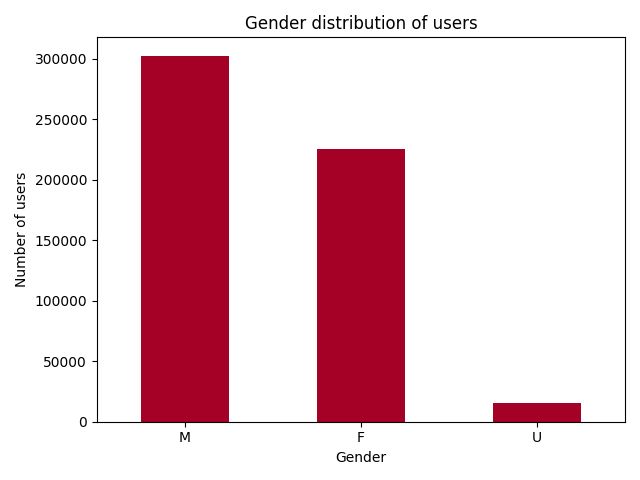

In [17]:
# I graph it
plt.clf()
df_new.groupby('gender').count().sort('count', ascending=False) \
.toPandas().plot.bar(x='gender', y='count', rot=0, legend=None, cmap = 'RdYlBu')
plt.title("Gender distribution of users")
plt.xlabel("Gender")
plt.ylabel("Number of users")
plt.tight_layout()
%matplot plt

In [18]:
# Let's see the 'level' distribution of subscribers
df_new.groupby('level').count().sort('level', ascending=[False]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------+
|level| count|
+-----+------+
| paid|428597|
| free|115108|
+-----+------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

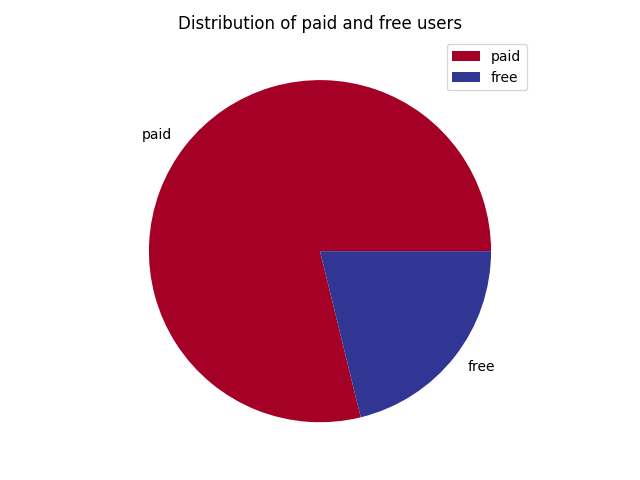

In [19]:
# A pie chart makes sense here, most of our users are paid users
labels = ['paid', 'free']
plt.clf()
df_new.groupby('level').count().sort('level', ascending=[False]) \
.toPandas().plot.pie(y='count', labels=labels, cmap = 'RdYlBu');
plt.ylabel("")
plt.title("Distribution of paid and free users")
plt.tight_layout()
%matplot plt

In [20]:
df_new.select('page').dropDuplicates().show(100, False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+

In [21]:
# Let's check the 'page' column
df_new.groupby('page').count().sort('count', ascending=False).show(100, False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |432877|
|Home                     |27412 |
|Thumbs Up                |23826 |
|Add to Playlist          |12349 |
|Add Friend               |8087  |
|Roll Advert              |7773  |
|Login                    |6011  |
|Logout                   |5990  |
|Thumbs Down              |4911  |
|Downgrade                |3811  |
|Help                     |3150  |
|Settings                 |2964  |
|About                    |1855  |
|Upgrade                  |968   |
|Save Settings            |585   |
|Error                    |519   |
|Submit Upgrade           |287   |
|Submit Downgrade         |117   |
|Cancellation Confirmation|99    |
|Cancel                   |99    |
|Register                 |11    |
|Submit Registration      |4     |
+-------------------------+------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

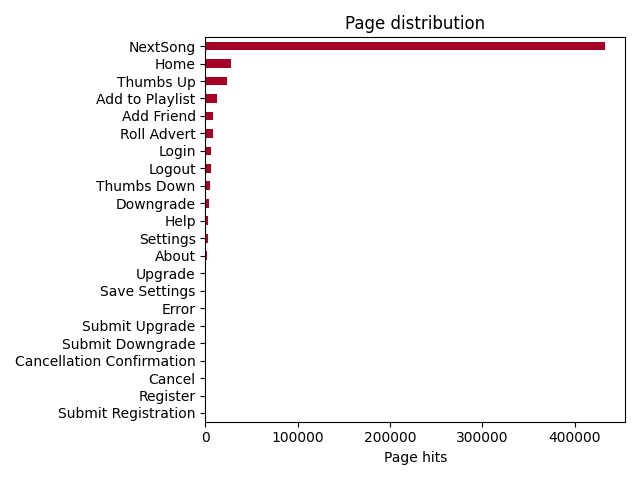

In [22]:
# The same in a graphical representation
plt.clf()
df_new.groupby('page').count().sort('count', ascending=True) \
.toPandas().plot.barh(x='page', y='count', rot=0, legend=None, cmap = 'RdYlBu')
plt.title("Page distribution")
plt.xlabel("Page hits")
plt.ylabel("")
plt.tight_layout()
%matplot plt

In [23]:
# We have 3 status: 200, 307 and 404
# the last two are failures 
df_new.groupby('status').count().sort('count', ascending=[False]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+------+
|status| count|
+------+------+
|   200|493269|
|   307| 49917|
|   404|   519|
+------+------+

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [24]:
# Source idea from here: https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253
major_df = df_new.where(df_new["churn"] == 0)
minor_df = df_new.where(df_new["churn"] == 1)

major_df_count = major_df.count()
minor_df_count = minor_df.count()

ratio = int(major_df_count/minor_df_count)
print("ratio: {}".format(ratio))

a = range(ratio)

# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows 
df_new = major_df.unionAll(oversampled_df)

print("df count before resample: {}".format(df.count()))

print("df count after resample: {}".format(df_new.count()))

# We can see that the 'churn' column is very less unbalanced now
df_new.groupby('churn').count().sort('count', ascending=[False]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ratio: 2516
df count before resample: 543705
df count after resample: 1086945
+-----+------+
|churn| count|
+-----+------+
|    0|543489|
|    1|543456|
+-----+------+

In [25]:
# I use a StringIndexer in the 'churn' column and named it 'label' as
# required by the Spark ML library in the respective section
churnIndexer = StringIndexer(inputCol="churn", outputCol="label")

# Transform teh column
df_new = churnIndexer.fit(df_new).transform(df_new)

# And delete the 'churn' column as I don't need it anymore
df_new = df_new.drop('churn')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# I apply a StringIndexer in this column as well
genderIndexer = StringIndexer(inputCol="gender", outputCol="gender_int")

# Transform it
df_new = genderIndexer.fit(df_new).transform(df_new)

# and delete the categorical
df_new = df_new.drop('gender')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# StringIndexer applied
levelIndexer = StringIndexer(inputCol="level", outputCol="level_int")

# Transform
df_new = levelIndexer.fit(df_new).transform(df_new)

# Column deleted
df_new = df_new.drop('level')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
# let's see what the 'location' column has to offer:
df_new.groupby('location').count().sort('count', ascending=[False]).show(20, False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------------------------+-----+
|location                                    |count|
+--------------------------------------------+-----+
|New York-Newark-Jersey City, NY-NJ-PA       |90456|
|Los Angeles-Long Beach-Anaheim, CA          |79548|
|Chicago-Naperville-Elgin, IL-IN-WI          |40344|
|Dallas-Fort Worth-Arlington, TX             |31181|
|Atlanta-Sandy Springs-Roswell, GA           |26301|
|Boston-Cambridge-Newton, MA-NH              |25119|
|San Francisco-Oakland-Hayward, CA           |24003|
|Philadelphia-Camden-Wilmington, PA-NJ-DE-MD |19537|
|Houston-The Woodlands-Sugar Land, TX        |16252|
|Phoenix-Mesa-Scottsdale, AZ                 |16214|
|Tampa-St. Petersburg-Clearwater, FL         |15875|
|null                                        |15700|
|Louisville/Jefferson County, KY-IN          |15002|
|Washington-Arlington-Alexandria, DC-VA-MD-WV|13726|
|Miami-Fort Lauderdale-West Palm Beach, FL   |13210|
|Orlando-Kissimmee-Sanford, FL               |

In [29]:
# The US, according to 'www2.census.gov', can be divided in 4 mayor regions: Region 1: Northeast, 
# Region 2: Midwest, Region 3: South and Region 4: West.
# Each of these regions can be divided further, for example, Region 1 is compromised of Division 1: 
# New England with Connecticut, Maine, Massachusetts, New Hampshire, RhodeIsland and, Vermont and so for.
# I just divided it into 4 Regions: Northeast, Midwest, South and West.
location_regions = {
    'Northeast': ['NJ', 'NY', 'PA', 'CT', 'ME', 'MA', 'NH', 'RI', 'VT'],
    'Midwest': ['IN', 'IL', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'DC', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'NM', 'MT', 'UT', 'NV', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
# Extract the State information from the 'location' column
df_new = df_new.withColumn('state', split(df_new['location'], ',').getItem(1))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
# Drop 'location' column as I don't need it anymore
df_new = df_new.drop('location')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
# A quick check on our newly created column 
df_new.select('state').distinct().sort('state').show(10, False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+
|state       |
+------------+
|null        |
| AK         |
| AL         |
| AR         |
| AR-OK      |
| AZ         |
| CA         |
| CO         |
| CT         |
| DC-VA-MD-WV|
+------------+
only showing top 10 rows

In [33]:
# let's check the 'userAgent' column
df_new.select('userAgent').show(5, False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                  |


In [34]:
# I extrtact the 'os' (Operating System) information as it may play a role in churn
df_new = df_new.withColumn('os', regexp_extract(col('userAgent'), r'\((\w+);?\s+', 1))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
# I also, extract the browser from the 'userAgent' column 
df_new = df_new.withColumn('browser', regexp_extract(col('userAgent'), r'\s(\w+)/\d+.\d+"?$', 1))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
# A summary that revealed 'empty' fields
df_new.groupby('browser').count().sort('count', ascending=[False]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+
|browser| count|
+-------+------+
| Safari|642801|
|Firefox|249372|
|       |179072|
|   null| 15700|
+-------+------+

In [37]:
# I first take care of nulls/nan filling them with 'Undefined'
df_new = df_new.fillna('Undefined', subset='browser')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
# I do the same with the 'empty' values as I am not sure what this really mean in this context
# maybe here the opinion of a subject matter expert will be beneficial or helpfull
df_new = df_new.withColumn('browser', when(df_new['browser'] == '', 'Undefined').otherwise(df_new['browser']))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
# The data looks fixed now
df_new.groupby('browser').count().sort('count', ascending=[False]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+------+
|  browser| count|
+---------+------+
|   Safari|642801|
|  Firefox|249372|
|Undefined|194772|
+---------+------+

In [40]:
# I do take care of them for the os as well filling them with 'Undefined'
df_new = df_new.fillna('Undefined', subset='os')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
# And all nulls corrected
df_new.groupby('os').count().sort('count', ascending=[False]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------+
|        os| count|
+----------+------+
|   Windows|502671|
| Macintosh|400744|
|       X11| 60238|
|    iPhone| 57236|
|compatible| 29322|
|      iPad| 21034|
| Undefined| 15700|
+----------+------+

In [42]:
# StringIndexer applied for both 'os' and 'browser'
osIndexer = StringIndexer(inputCol="os", outputCol="os_int")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
df_new = osIndexer.fit(df_new).transform(df_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
browserIndexer = StringIndexer(inputCol="browser", outputCol="browser_int")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
df_new = browserIndexer.fit(df_new).transform(df_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
# Columns deleted as I do not need them anymore
df_new = df_new.drop(*['os', 'browser'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
# I chech the 'ts' (timestamp) column
df_new.select(df_new.ts, length(df_new.ts)).show(5, False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+----------+
|ts           |length(ts)|
+-------------+----------+
|1538352011000|13        |
|1538352025000|13        |
|1538352118000|13        |
|1538352119000|13        |
|1538352124000|13        |
+-------------+----------+
only showing top 5 rows

In [48]:
# We do have the 'ts' in miliseconds, as it is 13 digits long, so we first need to 
# convert it to seconds dividing it by 1000. Then convert it to a date
df_new = df_new.withColumn('ts_date', from_unixtime(col('ts') / 1000))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
# From the new 'ts_date' column I extract the day of the week and the hour of the day
# 0 - Sunday, 1 - Monday, etc.
df_new = df_new.withColumn('day_of_week', dayofweek(col('ts_date')))
# Integer value for the hour
df_new = df_new.withColumn('hour', hour(col('ts_date')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
# Then I calculate the songs per hour
songs_per_hour = df_new.filter(df_new.page == "NextSong")\
                .groupby(df_new.hour).count()\
                .orderBy(df_new.hour.cast("float")).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
# And how many songs are played by day of the week
songs_per_day_of_week = df_new.filter(df_new.page == "NextSong")\
                .groupby(df_new.day_of_week).count()\
                .orderBy(df_new.day_of_week.cast("float")).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

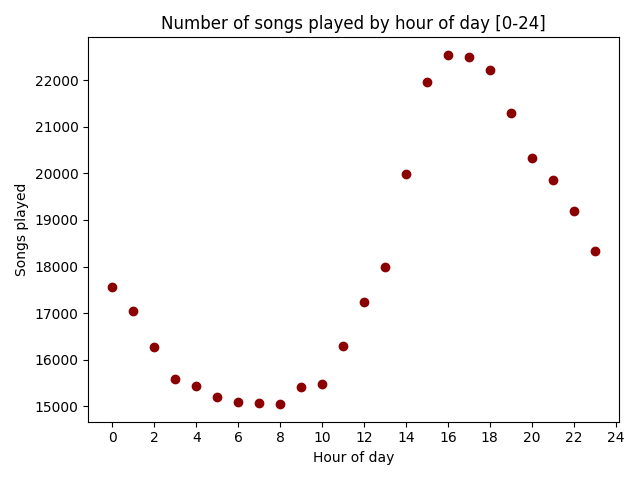

In [52]:
songs_per_hour.hour = pd.to_numeric(songs_per_hour.hour)

plt.clf()
plt.scatter(songs_per_hour["hour"], songs_per_hour["count"], color='darkred')
plt.xticks(np.arange(0, 26, 2))
plt.title("Number of songs played by hour of day [0-24]")
plt.xlabel("Hour of day")
plt.ylabel("Songs played")
plt.tight_layout()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

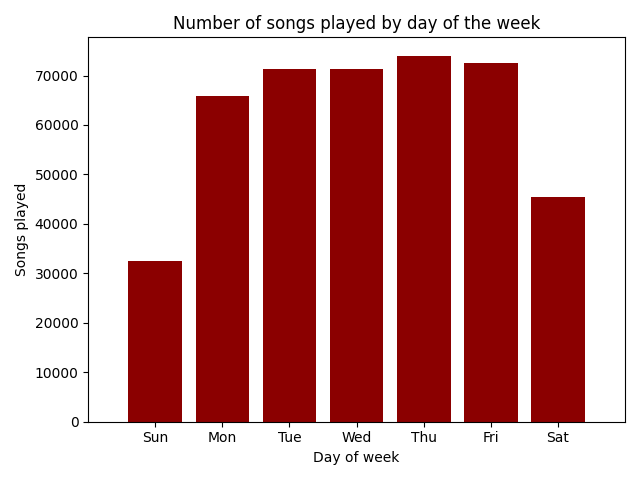

In [53]:
songs_per_day_of_week.day_of_week = pd.to_numeric(songs_per_day_of_week.day_of_week)
labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

plt.clf()
plt.bar(songs_per_day_of_week["day_of_week"], 
        songs_per_day_of_week["count"], 
        tick_label=labels, color='darkred')
plt.xlim(0, 8)
plt.title("Number of songs played by day of the week")
plt.xlabel("Day of week")
plt.ylabel("Songs played")
plt.tight_layout()
%matplot plt

In [54]:
# I define some features that define users interaction with the service.
# Here I capture the user saving settings as a measure of interaction
df_1 = df_new.select('userId', 'page')\
        .where('page = "Save Settings"')\
        .groupby('userId').count()\
       .withColumnRenamed('count', 'saved_settings')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
# then I merge the column into my dataframe
df_new = df_new.join(df_1, 'userId', 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
# calculate songs played by user
df_2 = df_new.select('userId', 'song')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'num_songs')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
df_new = df_new.join(df_2, 'userId', 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
# Thums up songs means a positive interaction with the syetm
# so I capture it
df_3 = df_new.select('userId', 'page')\
        .where('page = "Thumbs Up"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'thumbs_up')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
df_new = df_new.join(df_3, 'userId', 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
# For free users too many advertising could result in
# a poor perceived service, so I capture that as a feature
df_4 = df_new.select('userId', 'page')\
        .where('page = "Roll Advert"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'num_advertisement')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
df_new = df_new.join(df_4, 'userId', 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
# I thouhg conbining this with 'thumbs_up' as an indication of
# interaction of users with the service. I kept it separate as
# this particular feature may indicate that the recommended songs
# for the user are not good and hence he thumbs them down and maybe
# factors in him/her churning
df_5 = df_new.select('userId', 'page')\
        .where('page = "Thumbs Down"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'thumbs_down')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
df_new = df_new.join(df_5, 'userId', 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
# If users are adding lots of songs to their playlist
# that may indicate a user that wants to stay or convert 
# from free to paid, consequently not churning
df_6 = df_new.select('userId', 'page')\
        .where('page = "Add to Playlist"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'playlist_added')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
df_new = df_new.join(df_6, 'userId', 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
# Adding friends may mean something positive
df_7 = df_new.select('userId', 'page')\
        .where('page = "Add Friend"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'friend_added')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
df_new = df_new.join(df_7, 'userId', 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
# Errors are bad experience with the service so we need to
# capture that
df_8 = df_new.select('userId', 'page')\
        .where('page = "Error"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'errors_pages')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
df_new = df_new.join(df_8, 'userId', 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
# A user that listens lots of songs per session indicate
# users that are happy with the service
df_9 = df_new.where('page == "NextSong"') \
        .groupby(['userId', 'sessionId']) \
        .count() \
        .groupby(['userId']) \
        .agg({'count':'avg'}) \
        .withColumnRenamed('avg(count)', 'songs_persession')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
df_new = df_new.join(df_9, 'userId', 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
# I drop all the columns I do not need any longer to train my models
df_new = df_new.drop(*['ts_date', 'state', 'userAgent', 'ts', 'status', 'song', 'sessionId', 'page', 'length', 'auth', 'userId'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
# I define the 'features' column to use in the model
feature_columns = ['gender_int', 'level_int', 'os_int', 'browser_int', 'day_of_week', 
                   'hour', 'saved_settings', 'num_songs', 'thumbs_up', 'num_advertisement', 
                   'thumbs_down', 'playlist_added', 'friend_added', 'errors_pages', 'songs_persession']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
# I use VectorAssembler to vectorize the features
assembler = VectorAssembler(inputCols=feature_columns, outputCol='vector_features')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
# I transform the column
df_new = assembler.transform(df_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
# And normalize the data to avoid bias with higuer values in the feature vector
normalizer = Normalizer(inputCol='vector_features', outputCol='features')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [77]:
# Transform the vector
df_new = normalizer.transform(df_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
# df_new.coalesce(1)\
#     .write\
#     .format('json')\
#     .mode('overwrite')\
#     .save("s3n://pwolter-notebook-work/sparkify_cleaned_dataset.json")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [79]:
# Define the seed to use
seed = 1234

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
# The evaluator which is common to all models
evaluator = MulticlassClassificationEvaluator(labelCol='label')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [110]:
def confussion_matrix(predictor):
    """Receives a model's predictions dataframe and calculates the 
    precission and recall. Also prints out the true and false positive/negative
    values.
    Args:
    predictor:
        The predictions dataframe used to calculate precission and recall.
    Returns:
        Nothing
    """
    true_negative = predictor.select("*").where("prediction = 0 AND label = 0").count()
    true_positive = predictor.select("*").where("prediction = 1 AND label = 1").count()
    
    false_negative = predictor.select("*").where("prediction = 0 AND label = 1").count()
    false_positive = predictor.select("*").where("prediction = 1 AND label = 0").count()
    
    if (true_positive + false_positive) != 0:
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
    else:
        precision = 0
        recall = 0
        
    print("True Negative: {}\nTrue Positive: {}".format(true_negative, true_positive))
    print("False Negative: {}\nFalse Positive: {}".format(false_negative, false_positive))
    print("Precission: {}\nRecall: {}".format(precision, recall))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
def evaluation_metrics(evaluator, predictions):
    """Receives a model's evaluator and predictions dataframe and calculates 
    f-1, weighted precision, weighted recall and accuracy and prints them
    out.
    Args:
    evaluator:
        The evaluator used to calculate model metrics.
    predictor:
        The predictions dataframe used to calculate precission and recall.
    Returns:
        Nothing
    """
    f1 = evaluator.evaluate(predictions)
    wp = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
    wr = evaluator.setMetricName("weightedRecall").evaluate(predictions)
    accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
    
    print("F1:\t{}\nWP:\t{}\nWR:\t{}\nAccu:\t{}".format(f1, wp, wr, accuracy))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
# Split data set into train and test
train, test = df_new.randomSplit([0.8, 0.2], seed=seed)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Train different models to select the best to fine tune

## Logistic Regression

In [115]:
lr = LogisticRegression()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [116]:
lr_model = lr.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-116:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 11496



In [117]:
lr_predictions = lr_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [118]:
lr_predictions.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- label: double (nullable = false)
 |-- gender_int: double (nullable = false)
 |-- level_int: double (nullable = false)
 |-- os_int: double (nullable = false)
 |-- browser_int: double (nullable = false)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- saved_settings: long (nullable = false)
 |-- num_songs: long (nullable = false)
 |-- thumbs_up: long (nullable = false)
 |-- num_advertisement: long (nullable = false)
 |-- thumbs_down: long (nullable = false)
 |-- playlist_added: long (nullable = false)
 |-- friend_added: long (nullable = false)
 |-- errors_pages: long (nullable = false)
 |-- songs_persession: double (nullable = true)
 |-- vector_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

In [119]:
evaluation_metrics(evaluator, lr_predictions)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1:	0.7628022904431828
WP:	0.769676456111474
WR:	0.7628022904431828
Accu:	0.7628022904431828

## Random Forest Classifier

In [120]:
rf = RandomForestClassifier(featureSubsetStrategy='auto', maxDepth=2, seed=seed)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [121]:
rf_model = rf.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [122]:
rf_predictions = rf_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [123]:
evaluation_metrics(evaluator, rf_predictions)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1:	0.7451596875483624
WP:	0.7594169355597593
WR:	0.7451596875483624
Accu:	0.7451596875483624

## GBTClassifier

In [124]:
gbt = GBTClassifier(labelCol='label', maxDepth=2, seed=seed)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [125]:
gbt_model = gbt.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-125:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 13862



In [126]:
gbt_predictions = gbt_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [127]:
evaluation_metrics(evaluator, gbt_predictions)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1:	0.8090265616472946
WP:	0.8176838818844844
WR:	0.8090265616472945
Accu:	0.8090265616472946

## NaiveBayes classifier

In [128]:
nb = NaiveBayes()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [129]:
nb_model = nb.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-129:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 15592



In [130]:
nb_predictions = nb_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [131]:
evaluation_metrics(evaluator, nb_predictions)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1:	0.5888116900570982
WP:	0.34669920634789625
WR:	0.5888116900570982
Accu:	0.5888116900570982

# Best model hyperparameter tunning

In [101]:
gbt = GBTClassifier(labelCol='label', seed=seed)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [102]:
paramGrid = ParamGridBuilder() \
                    .addGrid(gbt.maxBins, [32]) \
                    .addGrid(gbt.maxDepth, [2, 4]) \
                    .addGrid(gbt.maxIter, [10]) \
                    .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [103]:
pipeline = Pipeline(stages=[gbt])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [104]:
cv = CrossValidator(estimator=pipeline, evaluator=evaluator, 
                    estimatorParamMaps=paramGrid, numFolds=5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [105]:
best_model = cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-105:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 2904



In [106]:
predictions = best_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [107]:
predictions.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- label: double (nullable = false)
 |-- gender_int: double (nullable = false)
 |-- level_int: double (nullable = false)
 |-- os_int: double (nullable = false)
 |-- browser_int: double (nullable = false)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- saved_settings: long (nullable = false)
 |-- num_songs: long (nullable = false)
 |-- thumbs_up: long (nullable = false)
 |-- num_advertisement: long (nullable = false)
 |-- thumbs_down: long (nullable = false)
 |-- playlist_added: long (nullable = false)
 |-- friend_added: long (nullable = false)
 |-- errors_pages: long (nullable = false)
 |-- songs_persession: double (nullable = true)
 |-- vector_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

In [108]:
evaluation_metrics(evaluator, predictions)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-108:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 10997



F1:	0.8558572632194241
WP:	0.8677495950984642
WR:	0.854713246613614
Accu:	0.8547132466136139

In [111]:
confussion_matrix(predictions)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-111:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 11292



True Negative: 58499
True Positive: 46435
False Negative: 4047
False Positive: 13790
Precission: 0.7710253217102532
Recall: 0.9198328116952578

In [112]:
predictions.select("RawPrediction","prediction") \
.orderBy("RawPrediction", ascending=True) \
.show(25, False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------+----------+
|RawPrediction                           |prediction|
+----------------------------------------+----------+
|[-1.1326146199279412,1.1326146199279412]|1.0       |
|[-1.1326146199279412,1.1326146199279412]|1.0       |
|[-1.1326146199279412,1.1326146199279412]|1.0       |
|[-1.1326146199279412,1.1326146199279412]|1.0       |
|[-1.1326146199279412,1.1326146199279412]|1.0       |
|[-1.0956189456572296,1.0956189456572296]|1.0       |
|[-1.0956189456572296,1.0956189456572296]|1.0       |
|[-1.0956189456572296,1.0956189456572296]|1.0       |
|[-1.0956189456572296,1.0956189456572296]|1.0       |
|[-1.0956189456572296,1.0956189456572296]|1.0       |
|[-1.0956189456572296,1.0956189456572296]|1.0       |
|[-1.0956189456572296,1.0956189456572296]|1.0       |
|[-1.0956189456572296,1.0956189456572296]|1.0       |
|[-1.0956189456572296,1.0956189456572296]|1.0       |
|[-1.0956189456572296,1.0956189456572296]|1.0       |
|[-1.0956189456572296,1.0956

In [113]:
best_model.bestModel.stages[0].featureImportances

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparseVector(15, {1: 0.0606, 3: 0.0318, 4: 0.1294, 5: 0.2192, 6: 0.0408, 7: 0.082, 8: 0.1039, 9: 0.0223, 10: 0.0024, 11: 0.1446, 12: 0.0765, 13: 0.0287, 14: 0.058})

In [114]:
best_model.bestModel.stages[0].extractParamMap()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{Param(parent='GBTClassifier_8b952f1e61d4', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='GBTClassifier_8b952f1e61d4', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='GBTClassifier_8b952f1e61d4', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all', Param(parent='GBTClassifier_8b952f1e61d4', name='featuresCol', doc='features column name'): 'features', Param(parent='GBTClassifier_8b952f1e61d4', name='labelCol', doc='label column name'): 'label'

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.